<a href="https://colab.research.google.com/github/kohathyli/Credeit-Default/blob/main/DURF_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve,auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.display import SVG, display
from graphviz import Source
from mlxtend.plotting import plot_decision_regions
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
df = pd.read_csv("default of credit card clients.csv")
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2       3913       3102        689          0          0   
1      0      2       2682       1725       2682       3272       3455   
2      0      0      29239      14027      13559      14331      14948   
3      0      0      46990      48233      49291      28314      28959   
4      0      0       8617       5670      35835      20940      19146   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0          0         0       689         0         0         0         0   
1       3261         0      1000      1000      1000         0      2000   
2      15549      1518      1500      1000      1000      1000      5000   
3      29547      2000      2019      1200      1100      1069      1000   
4      19131      2000     36681     10000      9000       689       679   

   default payment next month  
0                           1  
1                           1  
2                           0  
3                           0  
4                           0

In [7]:
df.rename(columns={"PAY_0": "PAY_1"}, inplace=True)
df["default payment next month"] = df["default payment next month"].astype('category')

In [8]:
# Null value composition
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_1                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [9]:
# Data type display
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   ID                          30000 non-null  int64   
 1   LIMIT_BAL                   30000 non-null  int64   
 2   SEX                         30000 non-null  int64   
 3   EDUCATION                   30000 non-null  int64   
 4   MARRIAGE                    30000 non-null  int64   
 5   AGE                         30000 non-null  int64   
 6   PAY_1                       30000 non-null  int64   
 7   PAY_2                       30000 non-null  int64   
 8   PAY_3                       30000 non-null  int64   
 9   PAY_4                       30000 non-null  int64   
 10  PAY_5                       30000 non-null  int64   
 11  PAY_6                       30000 non-null  int64   
 12  BILL_AMT1                   30000 non-null  int64   
 13  BILL_AMT2       

In [10]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [11]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [12]:
df['MARRIAGE']=np.where(df['MARRIAGE'] == 0, 3, df['MARRIAGE'])

df['EDUCATION']=np.where(df['EDUCATION'] == 5, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 6, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 0, 4, df['EDUCATION'])

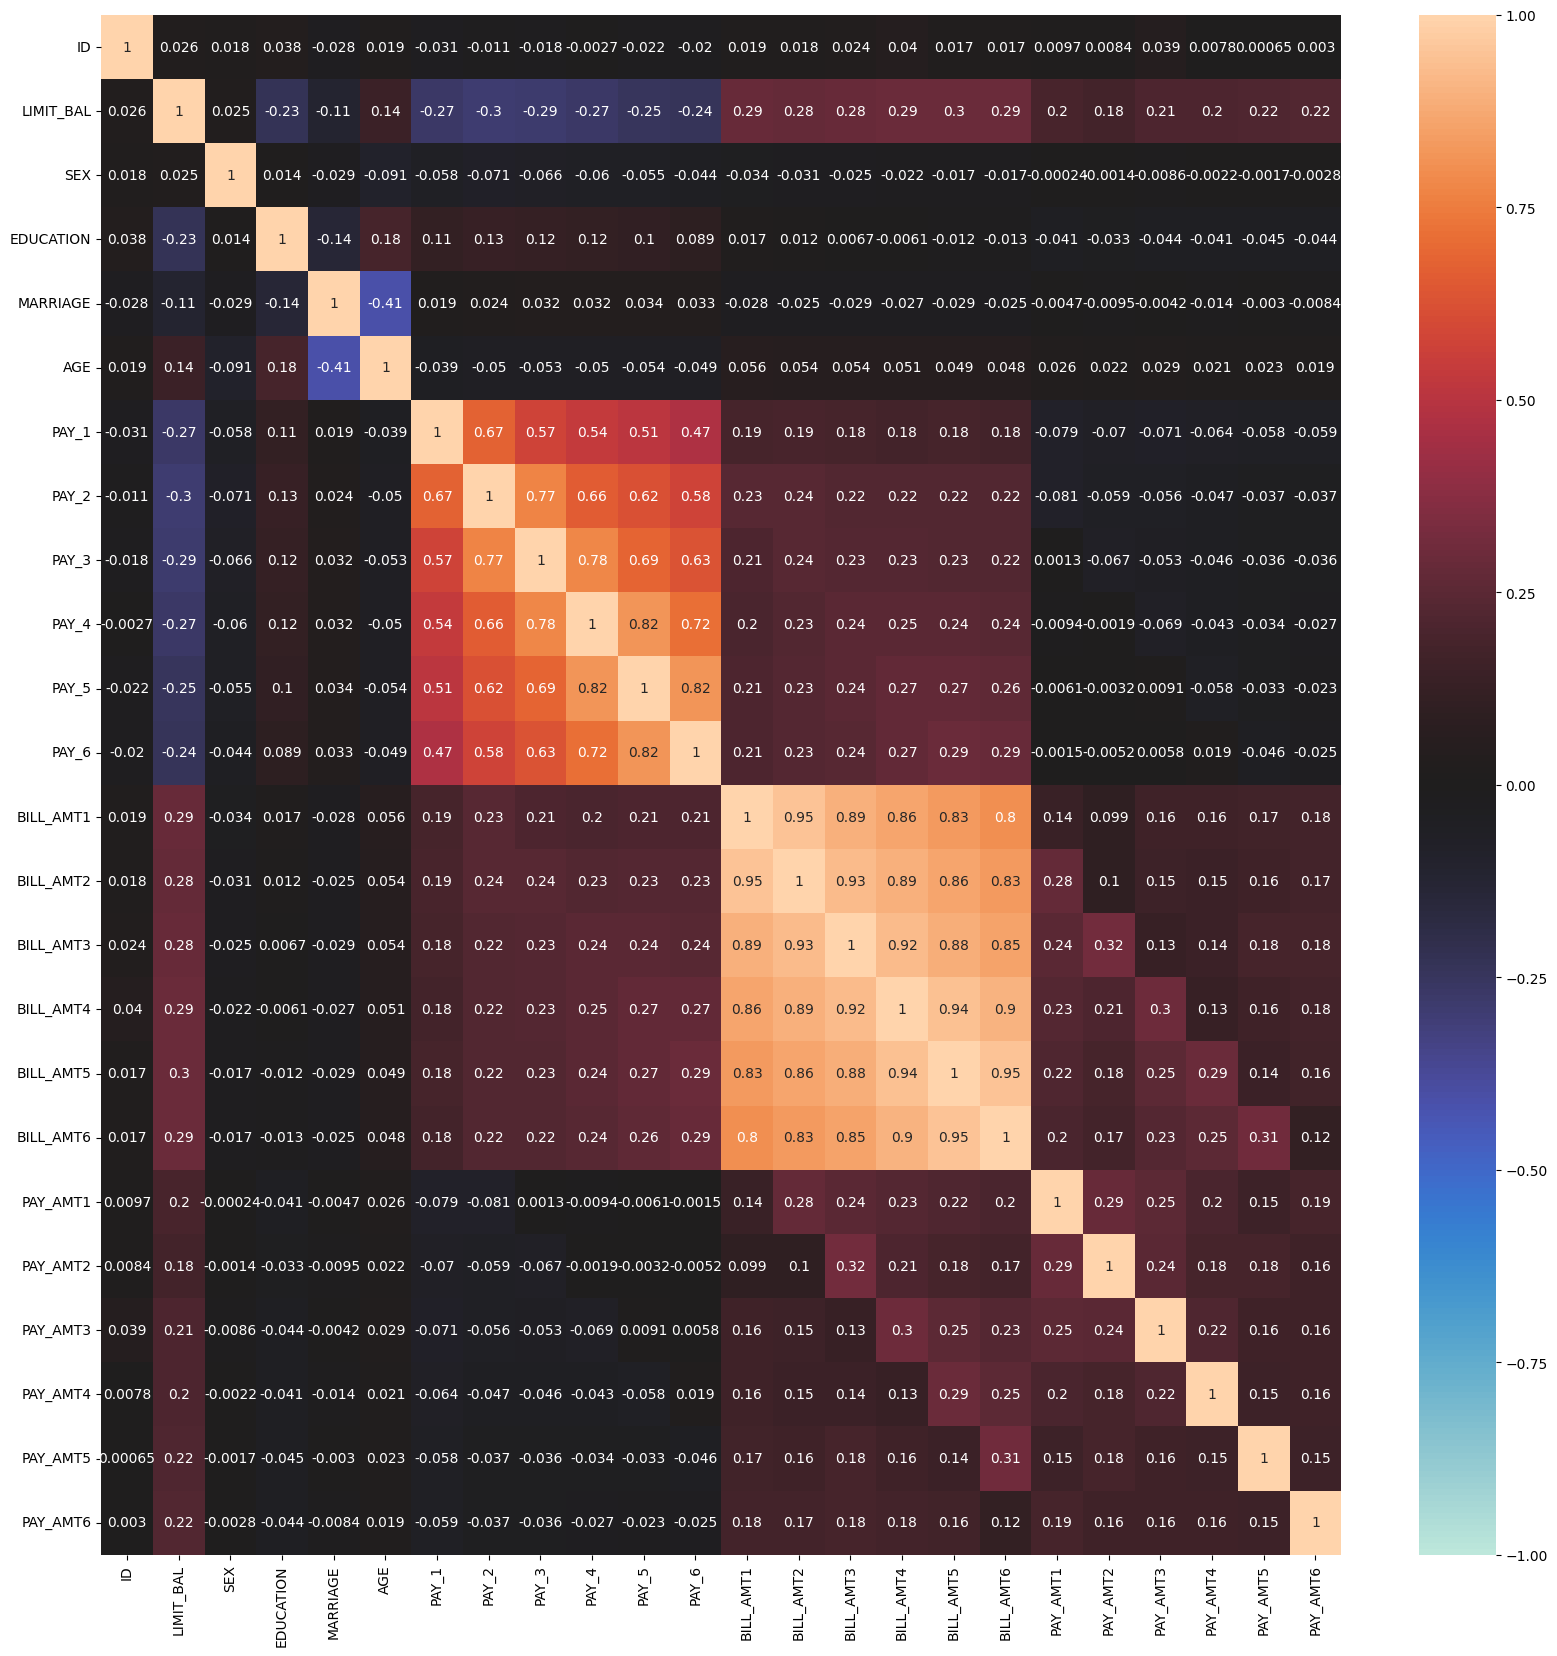

In [13]:
# Heatmap correlation with only features (X)
df_corr_y = df.copy()
plt.figure(figsize = (20,20))
sns.heatmap(df_corr_y.corr(), vmin=-1, vmax=1, center=0, annot=True)
plt.show()

In [14]:
numeric = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [15]:
data_num = df[numeric]

#scale on numerical columns--brings the value of each feature into the range of 0 to 1
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
def scaleNum(df_num, cols):
    for col in cols:
        df_num[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(data_num[col])),columns=[col])
    return df_num
data_normal_num = scaleNum(data_num,data_num.columns)
data_normal_num.head()

LIMIT_BAL       AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0   0.010101  0.051724   0.149982   0.069164   0.086723   0.160138   0.080648   
1   0.111111  0.086207   0.148892   0.067858   0.087817   0.163220   0.084074   
2   0.080808  0.224138   0.172392   0.079532   0.093789   0.173637   0.095470   
3   0.040404  0.275862   0.188100   0.111995   0.113407   0.186809   0.109363   
4   0.040404  0.620690   0.154144   0.071601   0.106020   0.179863   0.099633   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
0   0.260979  0.000000  0.000409  0.000000  0.000000  0.000000  0.000000  
1   0.263485  0.000000  0.000594  0.001116  0.001610  0.000000  0.003783  
2   0.272928  0.001738  0.000891  0.001116  0.001610  0.002345  0.009458  
3   0.283685  0.002290  0.001199  0.001339  0.001771  0.002506  0.001892  
4   0.275681  0.002290  0.021779  0.011160  0.014493  0.001615  0.001284

In [16]:
for att in ['SEX', 'EDUCATION', 'MARRIAGE']:
  df[att] = df[att].astype('category')

df=pd.concat([pd.get_dummies(df['SEX'], prefix='SEX'),
                pd.get_dummies(df['EDUCATION'], prefix='EDUCATION'),
                pd.get_dummies(df['MARRIAGE'], prefix='MARRIAGE'),
                df],axis=1)
# drop original columns
df.drop(['EDUCATION'],axis=1, inplace=True)
df.drop(['SEX'],axis=1, inplace=True)
df.drop(['MARRIAGE'],axis=1, inplace=True)

df.head()

SEX_1  SEX_2  EDUCATION_1  EDUCATION_2  EDUCATION_3  EDUCATION_4  \
0      0      1            0            1            0            0   
1      0      1            0            1            0            0   
2      0      1            0            1            0            0   
3      0      1            0            1            0            0   
4      1      0            0            1            0            0   

   MARRIAGE_1  MARRIAGE_2  MARRIAGE_3  ID  LIMIT_BAL  AGE  PAY_1  PAY_2  \
0           1           0           0   1      20000   24      2      2   
1           0           1           0   2     120000   26     -1      2   
2           0           1           0   3      90000   34      0      0   
3           1           0           0   4      50000   37      0      0   
4           1           0           0   5      50000   57     -1      0   

   PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  \
0     -1     -1     -2     -2       3913       3102        689          0   
1      0      0      0      2       2682       1725       2682       3272   
2      0      0      0      0      29239      14027      13559      14331   
3      0      0      0      0      46990      48233      49291      28314   
4     -1      0      0      0       8617       5670      35835      20940   

   BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0          0          0         0       689         0         0         0   
1       3455       3261         0      1000      1000      1000         0   
2      14948      15549      1518      1500      1000      1000      1000   
3      28959      29547      2000      2019      1200      1100      1069   
4      19146      19131      2000     36681     10000      9000       689   

   PAY_AMT6 default payment next month  
0         0                          1  
1      2000                          1  
2      5000                          0  
3      1000                          0  
4       679                          0

In [17]:
y = df['default payment next month']
X = df.drop('default payment next month', axis = 1, inplace = False)

In [18]:
# Check data set dimension
print(X.shape)
print("Number of samples:", X.shape[0])
print("Number of attributes:", X.shape[1])

(30000, 30)
Number of samples: 30000
Number of attributes: 30


In [19]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [20]:
FEATURE_SELECTION = False
corr = df[numeric].corr()

if FEATURE_SELECTION :
    # remove features with correlation coefficent >= 0.93
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.92)]
    print(to_drop) #['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
    df= df.drop(df[to_drop], axis = 1)

In [21]:
# address class imbalance -- over-sample the minority class in the training data
over = SMOTE(sampling_strategy=0.5)

steps = [
    ('over',over)
]
xs, ys = Pipeline(steps=steps).fit_resample(X_train, y_train)
class_cnt = dict(Counter(ys))
print('The new count of classes:', class_cnt)

The new count of classes: {0: 18691, 1: 9345}


In [22]:
# Machine learning model 1 training phase (Random Forest classifier gini index)

model_rfgi = RandomForestClassifier(criterion='gini')
model_rfgi.fit(xs, ys)

RandomForestClassifier()

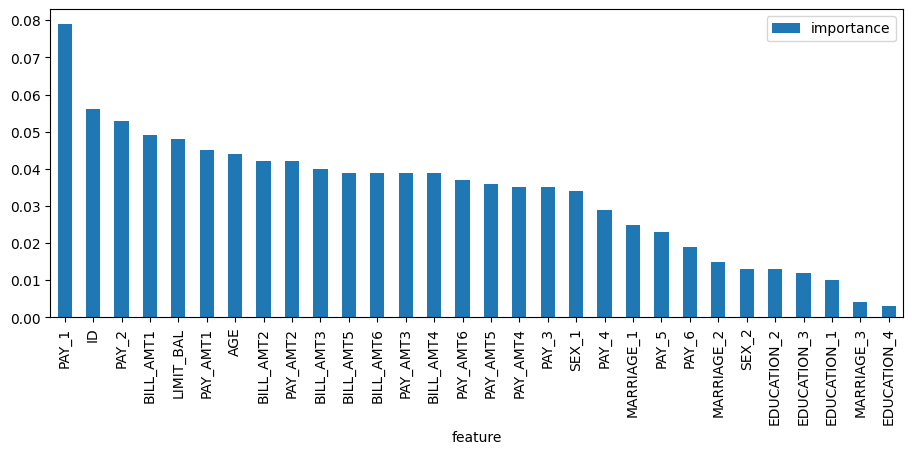

In [23]:
# feature importance analysis
# extract important features
score = np.round(model_rfgi.feature_importances_,3)
importances = pd.DataFrame({'feature':xs.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [24]:
# Machine learning model 2 training phase (Gradient boosting classifier)

model_gb = GradientBoostingClassifier()
model_gb.fit(xs, ys)

GradientBoostingClassifier()

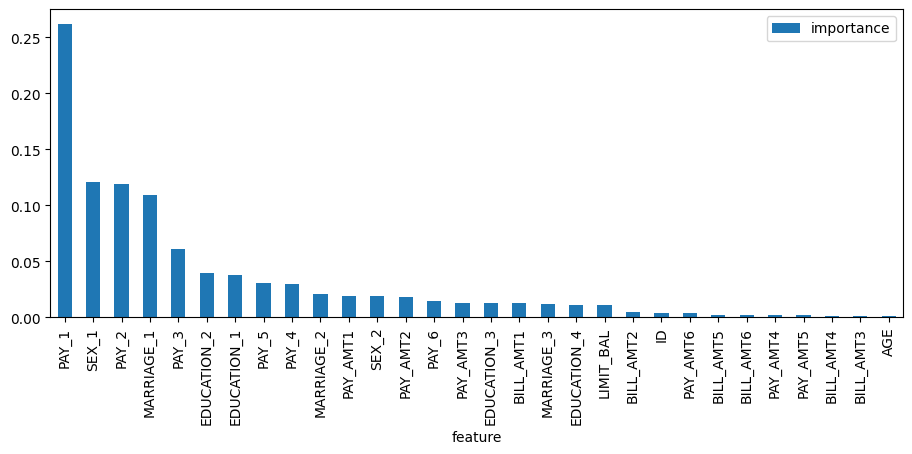

In [25]:
model_gb.fit(xs, ys);
# extract important features
score = np.round(model_gb.feature_importances_,3)
importances = pd.DataFrame({'feature':xs.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [26]:
# Machine learning model 1 testing phase (random forest)

pred_rfgi = model_rfgi.predict(X_test)
pred_rfgi

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
# combine the actual target values with the predicted target values
pd.DataFrame({'Actual':y_test,'RFGI':pred_rfgi})

Actual  RFGI
6907       0     0
24575      0     0
26766      0     0
2156       1     0
3179       0     0
29382      0     1
24454      0     0
23886      0     0
5504       0     0
29720      0     0
6908       0     0
2159       0     0
20842      1     0
25128      0     0
18808      0     0
19077      0     1
24731      0     0
3054       1     0
8488       0     0
23921      0     0
8787       0     0
15139      1     0
12738      0     0
25031      0     0
20339      1     0
10308      0     0
14601      0     0
3591       0     0
3560       1     1
24890      0     1
27481      1     0
10271      0     0
16625      1     1
26720      0     0
25615      0     0
8312       0     0
12179      0     0
1559       1     0
6133       0     0
24412      1     1
24095      0     0
29295      0     1
5519       0     0
6849       0     0
12313      0     0
24061      0     0
14989      0     0
28442      0     1
14701      0     0
27685      0     0
29568      0     0
28884      0     0
2421       1     1
9006       1     1
20660      1     0
20333      0     0
26443      0     0
10955      0     0
18159      0     0
12066      1     1
13425      0     0
9385       1     1
27184      1     0
22387      0     0
21906      0     0
7001       0     0
6744       1     0
17778      0     1
23307      1     0
22442      1     0
21143      1     0
27796      0     0
22407      0     0
9492       1     1
29958      0     0
7438       0     0
18922      0     0
26425      0     0
1046       1     0
19773      0     0
14583      1     1
13473      0     0
24176      0     0
9036       0     0
21393      1     1
11850      1     0
1132       0     0
25282      0     0
22533      0     0
15692      0     0
17399      0     0
8351       0     0
19582      0     0
19697      1     1
11946      1     0
20513      0     0
3926       0     0
23501      0     1
2656       1     0
17182      0     0
26570      0     0
11067      0     0
28079      0     0
26224      0     0
17282      1     0
4310       0     0
9718       1     0
7448       0     0
7937       0     0
28866      0     0
6347       0     1
20912      0     0
7017       0     0
1942       0     0
9818       0     0
19996      1     0
17720      0     0
15674      0     0
10311      0     0
20129      1     1
18056      0     0
14593      0     0
27748      1     1
4090       0     0
19735      0     0
26722      0     0
19294      0     0
9233       0     1
14821      0     0
23540      0     0
16729      1     1
17618      1     1
21998      0     0
23642      0     0
14973      1     1
9502       0     0
2751       0     0
25476      0     0
10324      0     0
4072       0     0
6882       0     0
7146       0     0
16125      1     1
18093      0     0
19645      0     0
3864       0     0
29015      1     1
6816       0     0
13741      1     0
14254      0     0
9011       1     1
197        0     0
7006       0     0
8331       0     0
17482      1     1
14915      0     0
6463       0     0
27676      0     0
4516       0     0
18621      0     0
19847      0     0
1496       1     1
13145      0     0
7814       0     0
15373      0     0
22790      0     0
2939       0     0
22035      0     0
10372      0     0
19930      0     0
25236      0     0
27368      0     0
8107       0     0
15960      0     0
28298      0     0
17846      1     1
14303      0     0
29681      1     0
3951       0     0
23767      0     1
11083      1     0
8946       0     0
12870      1     0
10337      1     1
15112      0     0
13900      0     0
5263       0     0
28532      1     1
10651      0     0
25425      0     0
21511      1     0
14662      0     0
4430       0     0
13347      0     0
27766      1     0
1757       0     1
28361      0     0
29141      0     0
21661      0     0
21806      0     0
14513      0     0
29214      1     1
25901      0     0
24207      0     0
2470       1     1
4749       0     0
6857       1     0
4655       0     0
802        0     0
27235      0    

In [28]:
# Machine learning model 3 testing phase (gradient boosting)

pred_gb = model_gb.predict(X_test)
pred_gb

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
pd.DataFrame({'actual':y_test,'GB':pred_gb})

actual  GB
6907       0   0
24575      0   0
26766      0   0
2156       1   0
3179       0   0
29382      0   0
24454      0   0
23886      0   0
5504       0   0
29720      0   0
6908       0   0
2159       0   0
20842      1   0
25128      0   0
18808      0   0
19077      0   1
24731      0   0
3054       1   0
8488       0   0
23921      0   0
8787       0   0
15139      1   0
12738      0   0
25031      0   0
20339      1   0
10308      0   0
14601      0   0
3591       0   0
3560       1   1
24890      0   0
27481      1   0
10271      0   0
16625      1   1
26720      0   0
25615      0   0
8312       0   0
12179      0   0
1559       1   0
6133       0   0
24412      1   1
24095      0   0
29295      0   1
5519       0   0
6849       0   0
12313      0   0
24061      0   0
14989      0   0
28442      0   1
14701      0   0
27685      0   0
29568      0   0
28884      0   0
2421       1   1
9006       1   1
20660      1   0
20333      0   0
26443      0   0
10955      0   0
18159      0   0
12066      1   1
13425      0   0
9385       1   1
27184      1   0
22387      0   0
21906      0   0
7001       0   0
6744       1   0
17778      0   1
23307      1   0
22442      1   0
21143      1   0
27796      0   0
22407      0   0
9492       1   1
29958      0   0
7438       0   0
18922      0   0
26425      0   0
1046       1   0
19773      0   0
14583      1   1
13473      0   0
24176      0   0
9036       0   0
21393      1   0
11850      1   0
1132       0   1
25282      0   0
22533      0   0
15692      0   0
17399      0   0
8351       0   0
19582      0   0
19697      1   1
11946      1   0
20513      0   0
3926       0   0
23501      0   0
2656       1   0
17182      0   0
26570      0   0
11067      0   0
28079      0   0
26224      0   0
17282      1   0
4310       0   0
9718       1   0
7448       0   0
7937       0   0
28866      0   0
6347       0   0
20912      0   0
7017       0   0
1942       0   0
9818       0   0
19996      1   0
17720      0   0
15674      0   0
10311      0   0
20129      1   1
18056      0   0
14593      0   0
27748      1   1
4090       0   0
19735      0   0
26722      0   0
19294      0   0
9233       0   1
14821      0   0
23540      0   0
16729      1   1
17618      1   0
21998      0   0
23642      0   0
14973      1   1
9502       0   0
2751       0   0
25476      0   0
10324      0   0
4072       0   0
6882       0   0
7146       0   0
16125      1   1
18093      0   0
19645      0   0
3864       0   0
29015      1   1
6816       0   0
13741      1   0
14254      0   0
9011       1   1
197        0   0
7006       0   0
8331       0   0
17482      1   1
14915      0   0
6463       0   0
27676      0   0
4516       0   0
18621      0   0
19847      0   0
1496       1   1
13145      0   0
7814       0   0
15373      0   0
22790      0   0
2939       0   0
22035      0   0
10372      0   0
19930      0   0
25236      0   0
27368      0   0
8107       0   0
15960      0   0
28298      0   0
17846      1   1
14303      0   0
29681      1   0
3951       0   0
23767      0   0
11083      1   0
8946       0   0
12870      1   0
10337      1   1
15112      0   0
13900      0   0
5263       0   0
28532      1   1
10651      0   0
25425      0   0
21511      1   0
14662      0   0
4430       0   0
13347      0   0
27766      1   0
1757       0   0
28361      0   0
29141      0   0
21661      0   0
21806      0   0
14513      0   0
29214      1   1
25901      0   0
24207      0   0
2470       1   1
4749       0   0
6857       1   0
4655       0   0
802        0   0
27235      0   1
15033      1   1
27198      1   0
15056      0   0
27652      0   0
6731       0   0
11710      0   0
19824      1   1
9130       1   1
22689      0   0
6571       0   0
22927      0   0
13980      0   0
18912      0   0
10328      0   0
9386       0   0
13136      0   0
16327      0   0
1357       1   1
20938      0   0
2008       1   0
12090      0   0
13874      0   0
21258      0   0
18955      1   0
20585      

In [30]:
# concatenate the training and testing data along with their corresponding labels
X = xs.append(X_test)
y = ys.append(y_test)

In [31]:
# convert the data to a NumPy array
X = X.values
y = y.values

In [32]:
# Machine learning model 1 optimization phase (randomized search for random forest)

rfgi_tuned_params = {   "max_depth": sp_randint(1, 4),
                      "min_samples_leaf"  : sp_randint(2, 11),
                      'min_samples_split' : sp_randint(2, 11)}
n_iter_search = 20
random_search = RandomizedSearchCV(model_rfgi, rfgi_tuned_params,
                                   n_iter = n_iter_search, cv=10)

random_search.fit(X, y)
print("Best Params : ",random_search.best_params_,"\n")
best_rfgi = random_search.best_params_

means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, random_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best Params :  {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 6} 

0.752 (+/-0.010) for {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 6}
0.753 (+/-0.013) for {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 6}
0.752 (+/-0.009) for {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 9}
0.723 (+/-0.010) for {'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.745 (+/-0.009) for {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.722 (+/-0.008) for {'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 8}
0.724 (+/-0.008) for {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.744 (+/-0.009) for {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 9}
0.753 (+/-0.011) for {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 6}
0.753 (+/-0.010) for {'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 2}
0.744 (+/-0.007) for {'max_depth': 2, 'min_samples_leaf': 7, 'min_s

In [33]:
# initialize the classifier with the optimized parameters
model_rfgi2 = RandomForestClassifier(criterion='gini', max_depth= best_rfgi['max_depth'], min_samples_leaf= best_rfgi['min_samples_leaf'], min_samples_split= best_rfgi['min_samples_split'])

In [34]:
model_rfgi2.fit(xs, ys)

RandomForestClassifier(max_depth=3, min_samples_leaf=8, min_samples_split=6)

In [35]:
model_rfgi2.predict(X_test)
model_rfgi2.score(X_test,y_test)

0.8011666666666667

In [36]:
# Machine learning model 2 optimization phase (randomized search for gradient boosting)

gb_tuned_params = {   "max_depth": sp_randint(1, 4),
                      "min_samples_leaf"  : sp_randint(2, 11),
                      'min_samples_split' : sp_randint(2, 11)}
# you can change it
n_iter_search = 20
random_search = RandomizedSearchCV(model_gb, gb_tuned_params,
                                   n_iter = n_iter_search, cv=5)

random_search.fit(X, y)
print("Best Params : ",random_search.best_params_,"\n")
best_gb = random_search.best_params_

means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, random_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best Params :  {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 9} 

0.762 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.813 (+/-0.084) for {'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 2}
0.813 (+/-0.084) for {'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 2}
0.813 (+/-0.084) for {'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 6}
0.762 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 8, 'min_samples_split': 4}
0.812 (+/-0.083) for {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 8}
0.762 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 8}
0.762 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 8, 'min_samples_split': 4}
0.762 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 2}
0.762 (+/-0.007) for {'max_depth': 1, 'min_samples_leaf': 7, 'min_samples_split': 4}
0.827 (+/-0.115) for {'max_depth': 3, 'min_samples_leaf': 8, 'min_sa

In [37]:
model_gb2 = GradientBoostingClassifier(max_depth= best_gb["max_depth"], min_samples_leaf= best_gb["min_samples_leaf"], min_samples_split= best_gb["min_samples_split"])

In [38]:
model_gb2.fit(xs, ys)

GradientBoostingClassifier(min_samples_leaf=8, min_samples_split=9)

In [39]:
model_gb2.score(X_test,y_test)

0.8175

In [40]:
# plot the ROC curve for a certain classifier
def fig_roc(clf,X_train, X_test, y_train, y_test):
    clf.fit(X_train,y_train)
    y_scores = clf.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
    fp,tp,thresholds=roc_curve(y_test, y_scores, pos_label=1)
    AUC=auc(fp,tp)*100
    plt.plot(fp, tp, color='blue',label = 'AUC = %0.2f' % AUC)
    t=str(clf)
    plt.title('Receiver Operating Characteristic'+t)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

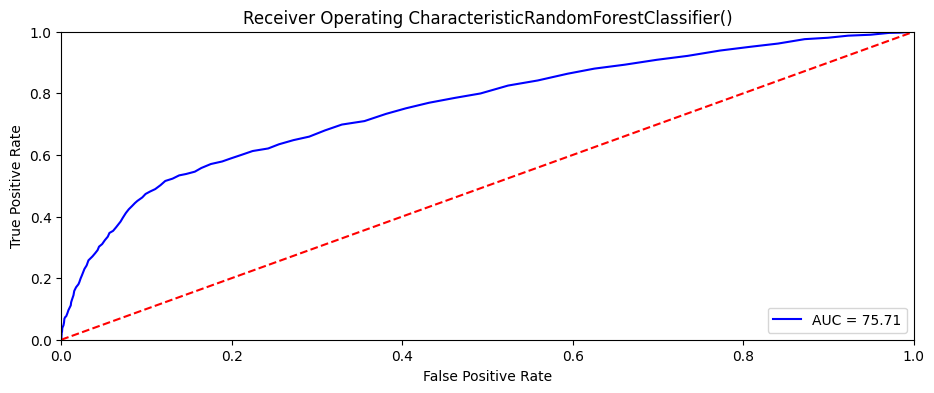

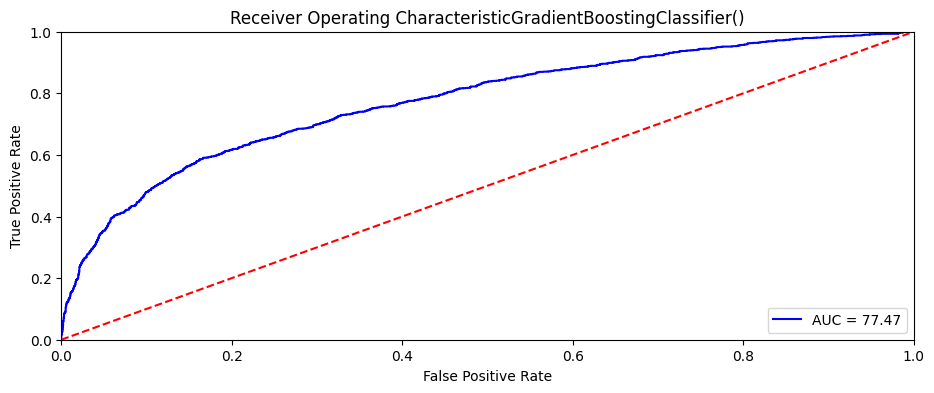

In [41]:
fig_roc(model_rfgi,xs, X_test, ys, y_test)
fig_roc(model_gb,xs, X_test, ys, y_test)

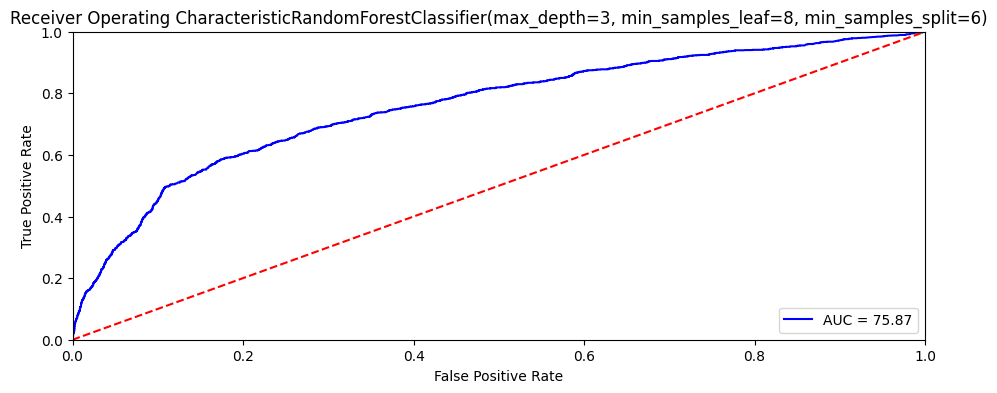

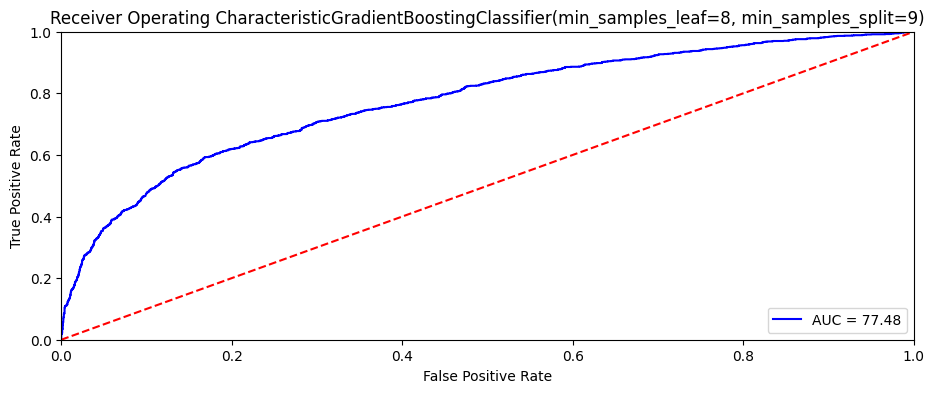

In [42]:
fig_roc(model_rfgi2,xs, X_test, ys, y_test)
fig_roc(model_gb2,xs, X_test, ys, y_test)

In [43]:
# Model analysis

print("Random Forest Gini Index")
print("Accuracy : ", model_rfgi.score(X_test,y_test)*100,"%\n")

print("Gradient Boosting")
print("Accuracy : ", model_gb.score(X_test,y_test)*100,"%\n")

modscore = [model_rfgi.score(X_test,y_test),\
           model_gb.score(X_test,y_test)]
maxim = max(modscore)
model = ["Random Forest Gini Index","Gradient Boosting"]

print("The best performing model before optimization is ",model[modscore.index(maxim)]," with accuracy ", maxim*100,"%\n")

Random Forest Gini Index
Accuracy :  81.01666666666667 %

Gradient Boosting
Accuracy :  81.91666666666667 %

The best performing model before optimization is  Gradient Boosting  with accuracy  81.91666666666667 %



In [44]:
# Result after optimization phase

print("Random Forest Gini Index")
print("Accuracy : ", model_rfgi2.score(X_test,y_test)*100,"%\n")

print("Gradient Boosting")
print("Accuracy : ", model_gb2.score(X_test,y_test)*100,"%\n")

modscore2 = [model_rfgi2.score(X_test,y_test),\
           model_gb2.score(X_test,y_test)]
maxim2 = max(modscore2)
model = ["Random Forest Gini Index","Gradient Boosting"]

print("The model with the best results after optimization is ",model[modscore2.index(maxim2)]," with accuracy ", maxim2*100,"%\n")

Random Forest Gini Index
Accuracy :  79.81666666666666 %

Gradient Boosting
Accuracy :  81.75 %

The model with the best results after optimization is  Gradient Boosting  with accuracy  81.75 %



In [45]:
df['TOTAL_BILL_AMT'] = df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6']
df['TOTAL_PAY_AMT'] = df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6']

In [46]:
predict_proba = model_gb2.predict_proba(X_test)
default_df = df.iloc[X_test.index]
default_df['default payment next month'] = y_test
default_df['DEFAULT_PROB'] = predict_proba[:,1]
default_df['OUTSTANDING'] = default_df['TOTAL_BILL_AMT'] - default_df['TOTAL_PAY_AMT']
default_df['DEFAULT_IMPORTANCE'] = round(default_df['OUTSTANDING'] * default_df['DEFAULT_PROB'], 2)
default_df.sort_values(by='DEFAULT_IMPORTANCE', ascending=False)[['DEFAULT_IMPORTANCE']].head(20)

DEFAULT_IMPORTANCE
15593          1875744.63
15316          1600539.14
19899          1566405.40
7048           1516963.43
22656          1513054.50
1496           1451392.29
27221          1431017.18
214            1427180.37
1181           1384021.52
20992          1337819.25
19595          1330659.99
23169          1310761.56
29150          1274813.89
16519          1245232.31
1132           1215706.08
20724          1207267.47
11245          1194925.16
9761           1186658.17
23039          1167983.90
9011           1149187.82

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import metrics

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')

In [48]:
default_df.describe()[['DEFAULT_PROB', 'DEFAULT_IMPORTANCE']]

# The top 25% for default probability is above 0.36

DEFAULT_PROB  DEFAULT_IMPORTANCE
count   6000.000000        6.000000e+03
mean       0.248848        5.953769e+04
std        0.192209        1.323533e+05
min        0.034926       -1.119219e+05
25%        0.120701        7.747625e+02
50%        0.180025        2.055661e+04
75%        0.283087        5.921423e+04
max        0.852086        1.875745e+06

Text(0.5, 1.0, 'Scatterplot of Default Probability and Outstanding Amt')

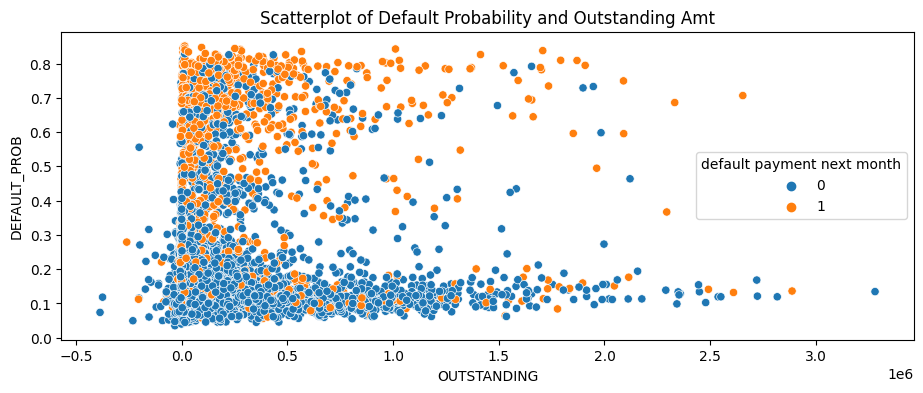

In [49]:
sns.scatterplot(data=default_df, x='OUTSTANDING', y='DEFAULT_PROB', hue='default payment next month')

plt.title('Scatterplot of Default Probability and Outstanding Amt')

In [50]:
cols_for_clustering = [
                    'DEFAULT_IMPORTANCE', # = Default Proba * Outstanding
                    'LIMIT_BAL'
                      ]

cluster_df = default_df[cols_for_clustering]

cluster_df.head()

DEFAULT_IMPORTANCE  LIMIT_BAL
6907               -21.62      50000
24575            -2458.33     150000
26766            60500.71      50000
2156            168253.90     290000
3179             -1065.52     500000

In [51]:
# Scaling / Standardization

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

cols_to_scale = cluster_df.columns

# Scale the columns
cluster_df_scaled = cluster_df.copy()
cluster_df_scaled[cols_to_scale] = scaler.fit_transform(cluster_df[cols_to_scale])

# Assign weights to columns
weights = np.array([4, 1]) # Weightage affects silhouette score of clusters and collected sum

cluster_df_scaled = cluster_df_scaled * weights

In [52]:
cluster_df_scaled.describe().T

count      mean       std  min       25%       50%  \
DEFAULT_IMPORTANCE  6000.0  0.345047  0.266349  0.0  0.226792  0.266601   
LIMIT_BAL           6000.0  0.199953  0.165441  0.0  0.050633  0.164557   

                         75%  max  
DEFAULT_IMPORTANCE  0.344396  4.0  
LIMIT_BAL           0.291139  1.0

Text(0.5, 1.0, 'Elbow plot of Kmeans clusters')

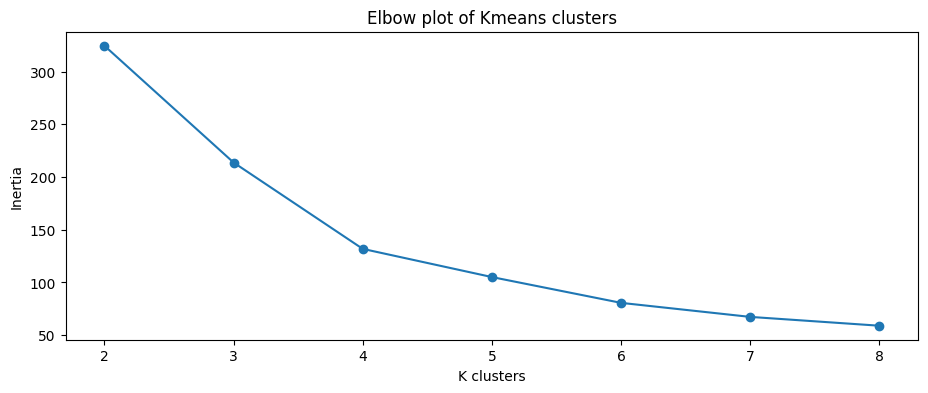

In [53]:
# Find the optimum clusters using an elbow plot

errors = {}
silhouette_scores = {}

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(cluster_df_scaled)
    errors[k] = kmeans.inertia_
    y_pred = kmeans.predict(cluster_df_scaled)
    silhouette_scores[k] = silhouette_score(cluster_df_scaled, y_pred)

plt.plot(errors.keys(), errors.values(), marker='o')
plt.xlabel('K clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot of Kmeans clusters')

Text(0.5, 1.0, 'Plot of Silhouette scores for K clusters')

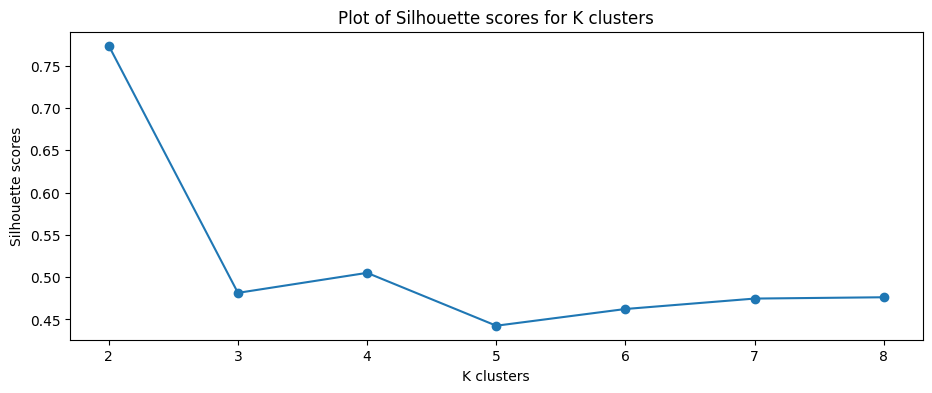

In [54]:
plt.plot(silhouette_scores.keys(), silhouette_scores.values() , marker='o');
plt.xlabel('K clusters')
plt.ylabel('Silhouette scores')
plt.title('Plot of Silhouette scores for K clusters')

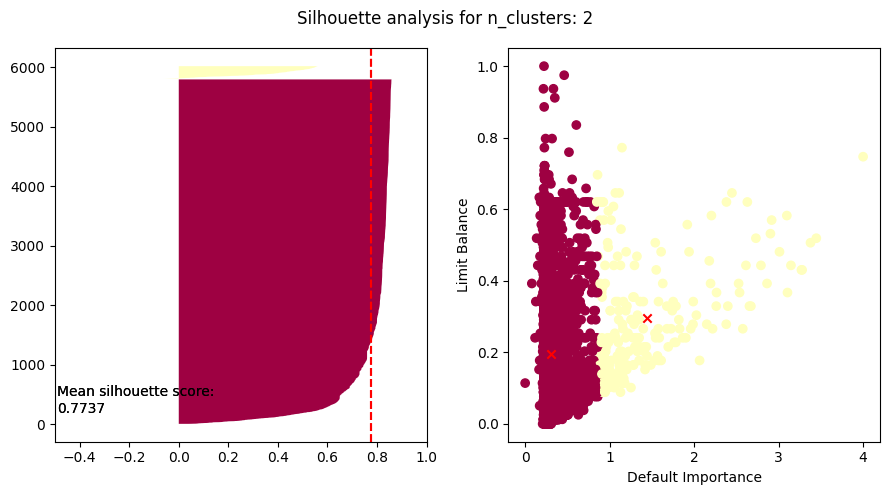

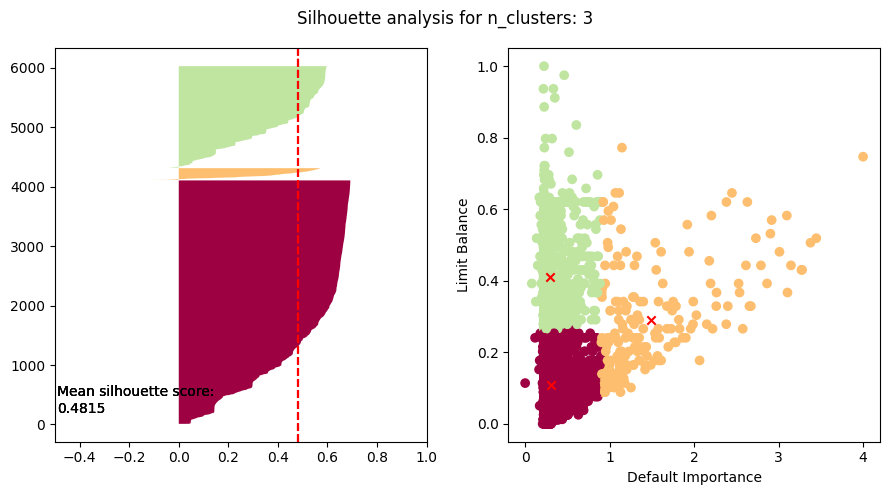

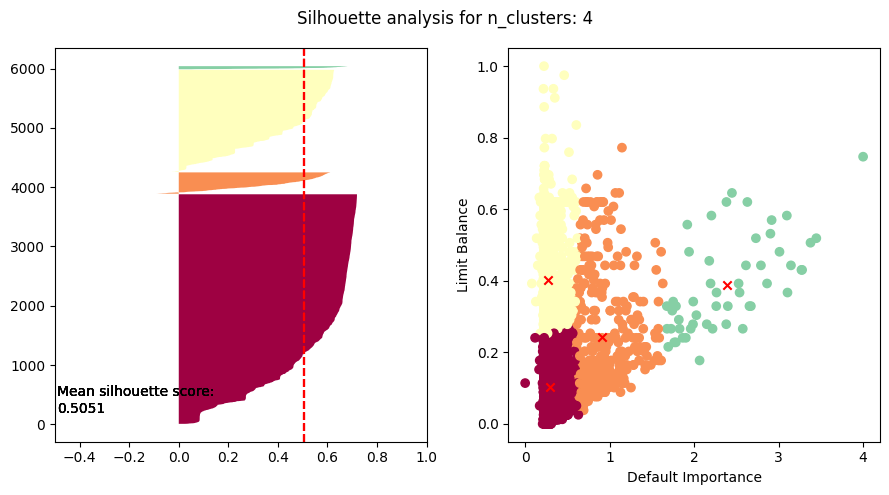

In [55]:
for k in range(2,5):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(cluster_df_scaled)
    labels = kmeans.predict(cluster_df_scaled)
    centroids = kmeans.cluster_centers_

    sil_samp = silhouette_samples(cluster_df_scaled, labels)
    sil_overall = silhouette_score(cluster_df_scaled, labels)

    y_lower = 10

    plt.figure(figsize=(9,5))
    plt.suptitle(f'Silhouette analysis for n_clusters: {k}')

    # for each cluster in total K clusters
    for n in range(k):

        # get coeff scores for the n cluster
        sil_coeff = sil_samp[labels == n]
        sil_coeff.sort() # sort for small to large
        y_upper = y_lower + len(sil_coeff)

        # get number of points in that cluster
        y_points = np.linspace(y_lower, y_upper, len(sil_coeff))


        plt.subplot(1, 2, 1)
        plt.xlim(-.5, 1)
        plt.annotate(f'Mean silhouette score: \n' + str(sil_overall.round(4)), (-0.49, 200))

        cmap = plt.get_cmap("Spectral")
        color = cmap(float(n)/k)
        plt.fill_betweenx(y_points, sil_coeff, facecolor=color)
        plt.axvline(x = sil_overall, linestyle='--', c='r')

        y_lower = y_upper + 10 # set the lower limit for the next cluster

    plt.subplot(1, 2, 2)
    colors = cmap(labels.astype(float)/k)
    plt.scatter(cluster_df_scaled.iloc[:,0], cluster_df_scaled.iloc[:,1], c=colors)
    plt.xlabel('Default Importance')
    plt.ylabel('Limit Balance')

    # plot the cluster centers
    plt.scatter(centroids[:, 0], centroids[:, 1], color='r', marker='x',);
    plt.tight_layout()

Based on the plots above, I'm leaning towards 4 clusters because it can capture a larger grouping of high default importance users, compared to other clusters.

In [56]:
kmeans = KMeans(n_clusters=4, random_state=42)
y_pred = kmeans.fit_predict(cluster_df_scaled)
print('Kmeans silhouette score:', silhouette_score(cluster_df_scaled, y_pred))

agglo = AgglomerativeClustering(n_clusters=4)
y_pred2 = agglo.fit_predict(cluster_df_scaled)
print('Agglomerative silhouette score:', silhouette_score(cluster_df_scaled, y_pred2))

Kmeans silhouette score: 0.5051450654920163
Agglomerative silhouette score: 0.43450282420242986


In [57]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(cluster_df_scaled)

default_df['SEGMENT'] = labels


Highest default importance segment: SEGMENT 3
Size of segment: 0.8666666666666666 %
Features used for clustering: ['DEFAULT_IMPORTANCE', 'LIMIT_BAL']
Weights: [4 1]


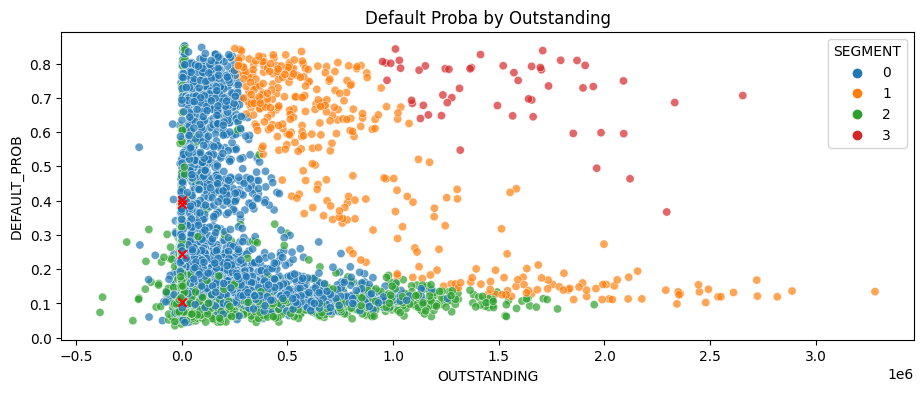

In [58]:
# group by segments
segment_groups = default_df.groupby(by='SEGMENT')

# Get segment with highest default importance
highest_segment = np.argmax(segment_groups['DEFAULT_IMPORTANCE'].mean())
print('Highest default importance segment: SEGMENT', highest_segment)

# Get size of segment
print('Size of segment:', segment_groups.get_group(highest_segment).count()[0] / default_df.shape[0] * 100, '%')

print('Features used for clustering:', cols_for_clustering)
print('Weights:', weights)

# Plot scatterplot of segments
sns.scatterplot(data=default_df, x='OUTSTANDING', y='DEFAULT_PROB', hue='SEGMENT', palette='tab10', alpha=0.7);

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], color='r', marker='x',);
plt.title('Default Proba by Outstanding');

Text(0.5, 1.0, 'Default Importance by Limit Balance')

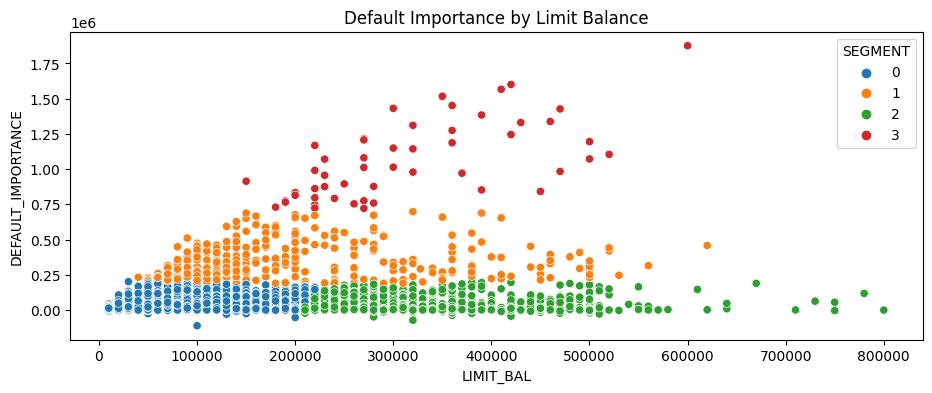

In [59]:
# Plot scatterplot of segments
sns.scatterplot(data=default_df, x='LIMIT_BAL', y='DEFAULT_IMPORTANCE', hue='SEGMENT', palette='tab10');
plt.title('Default Importance by Limit Balance')

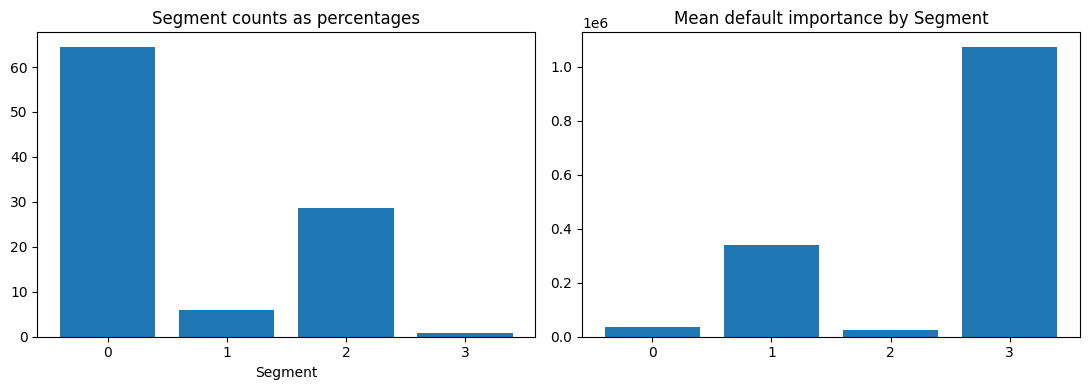

In [60]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.bar(segment_groups['ID'].count().keys(), segment_groups['ID'].count().values/segment_groups['ID'].count().sum()*100)
plt.xticks(range(k))
plt.xlabel('Segment')
plt.title('Segment counts as percentages');

segment_groups['ID'].count()

plt.subplot(1,2,2)
plt.bar(range(k), segment_groups['DEFAULT_IMPORTANCE'].mean())
plt.xticks(range(k))
plt.title('Mean default importance by Segment');

plt.tight_layout()

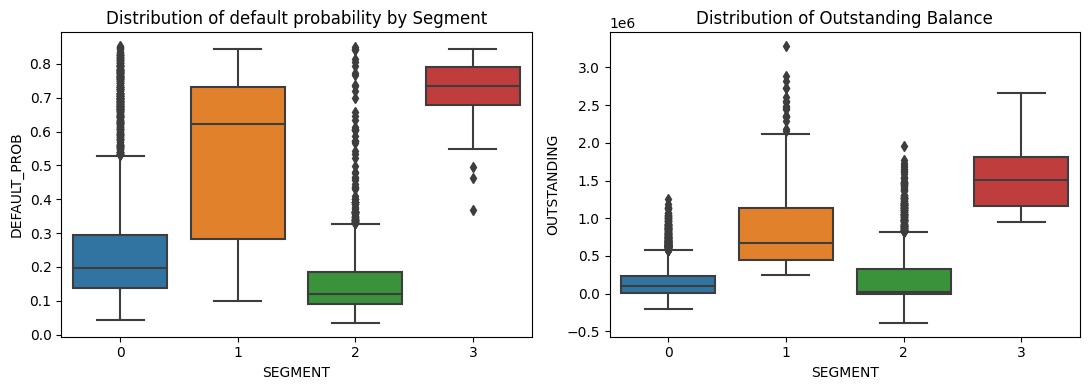

In [61]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.boxplot(x='SEGMENT', y='DEFAULT_PROB', data=default_df)
plt.title('Distribution of default probability by Segment');
segment_groups['DEFAULT_PROB'].mean().round(2)

plt.subplot(1,2,2)
sns.boxplot(x='SEGMENT', y='OUTSTANDING', data=default_df)
plt.title('Total bill amount for each segment');
plt.title('Distribution of Outstanding Balance');

plt.tight_layout()

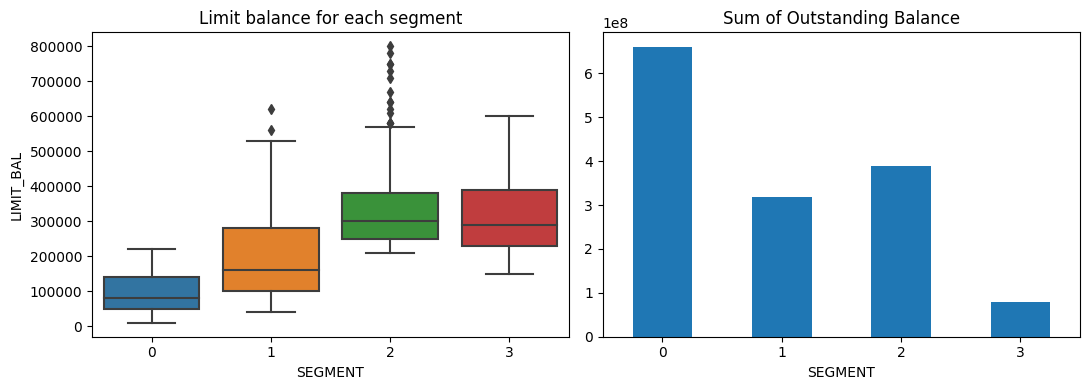

In [62]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.boxplot(x='SEGMENT', y='LIMIT_BAL', data=default_df, palette='tab10')
plt.title('Limit balance for each segment');

plt.subplot(1,2,2)
segment_groups['OUTSTANDING'].sum().plot(kind='bar', rot=0)
plt.title('Sum of Outstanding Balance');

plt.tight_layout()

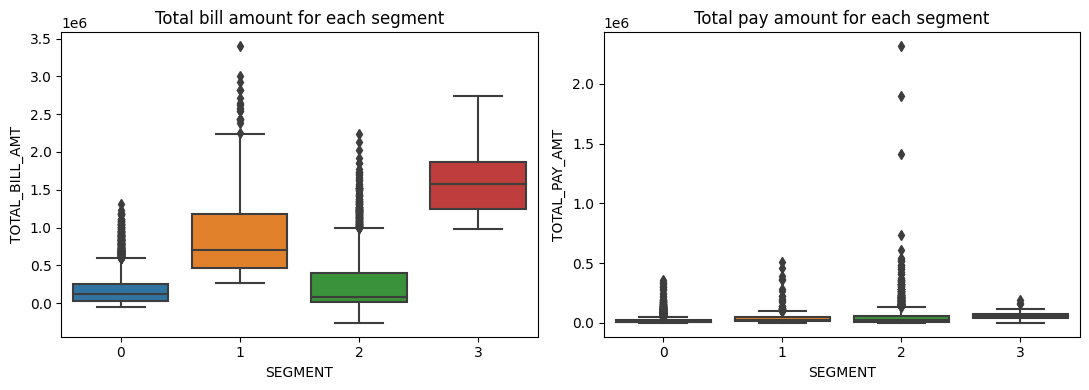

In [63]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.boxplot(x='SEGMENT', y='TOTAL_BILL_AMT', data=default_df)
plt.title('Total bill amount for each segment');

plt.subplot(1,2,2)
sns.boxplot(x='SEGMENT', y='TOTAL_PAY_AMT', data=default_df, palette='tab10')
plt.title('Total pay amount for each segment');

plt.tight_layout()

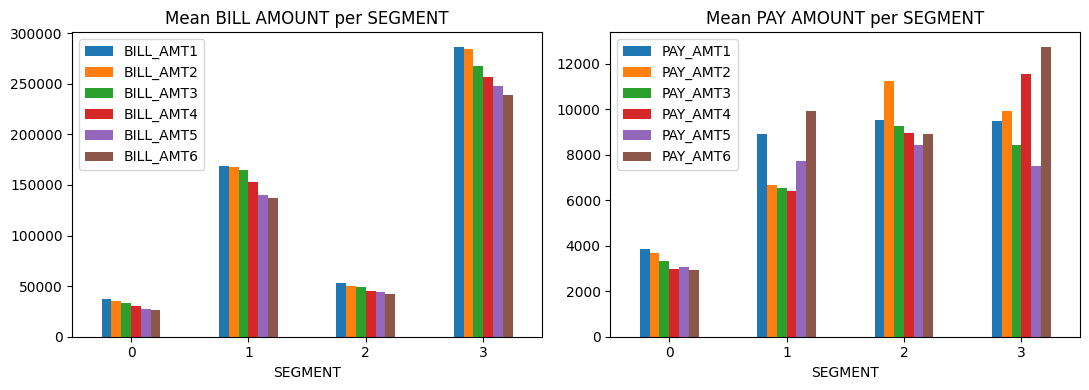

In [64]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
bill_amt_mean = segment_groups[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean()
bill_amt_mean.plot(kind='bar', ax=plt.gca(), rot=0)
plt.title('Mean BILL AMOUNT per SEGMENT');

plt.subplot(1,2,2)
pay_amt_mean = segment_groups[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean()

pay_amt_mean.plot(kind='bar', ax=plt.gca(), rot=0)
plt.title('Mean PAY AMOUNT per SEGMENT');

plt.tight_layout()

# the high risk/high default importance group has the highest mean bill amount in past 6 months.

In [65]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.histplot(data=default_df, x="AGE", hue="SEGMENT", multiple="layer", kde=True, palette='tab10', bins=30)
plt.title('AGE distribution for segments');

plt.subplot(1,2,2)
segment_groups.get_group(highest_segment)['AGE'].hist(bins=20)
plt.title(f'Age distribution of High Priority Segment');

plt.grid(False)
plt.tight_layout()

# Age distribution mainly between 21 to 55

In [164]:
default_df.head()

SEX_1  SEX_2  EDUCATION_1  EDUCATION_2  EDUCATION_3  EDUCATION_4  \
6907       1      0            0            1            0            0   
24575      1      0            1            0            0            0   
26766      1      0            0            1            0            0   
2156       0      1            1            0            0            0   
3179       0      1            0            1            0            0   

       MARRIAGE_1  MARRIAGE_2  MARRIAGE_3     ID  LIMIT_BAL  AGE  PAY_1  \
6907            0           1           0   6908      50000   46     -1   
24575           1           0           0  24576     150000   31     -1   
26766           0           1           0  26767      50000   25      0   
2156            0           1           0   2157     290000   25      0   
3179            1           0           0   3180     500000   27     -2   

       PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  \
6907      -1     -1     -1      0      0       1540      26060          0   
24575     -1     -2     -2     -2     -1      15000          0          0   
26766      0      0      0      0      0      48065      48355      49009   
2156       0      0      0      0      0     305823     303701     296384   
3179      -2     -2     -2     -2     -2      11354       9983      13570   

       BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
6907        2650       3320       2764     26060         0      3472   
24575          0          0      11694         0         0         0   
26766      49949      50479      50702      1800      1844      2200   
2156      248801     241983     230925     15000     10500     10000   
3179       10000      10000      10000      9983     13587     10000   

       PAY_AMT4  PAY_AMT5  PAY_AMT6 default payment next month  \
6907       2320      1764      2841                          0   
24575         0     11694     30000                          0   
26766      2000      1800      2038                          0   
2156      15000      7844     23333                          1   
3179      10000     10000     25304                          0   

       TOTAL_BILL_AMT  TOTAL_PAY_AMT  DEFAULT_PROB  OUTSTANDING  \
6907            36334          36457      0.182886         -123   
24575           26694          41694      0.160968       -15000   
26766          296559          11682      0.208683       284877   
2156          1627617          81677      0.114540      1545940   
3179            64907          78874      0.067249       -13967   

       DEFAULT_IMPORTANCE  SEGMENT  
6907               -22.49        0  
24575            -2414.52        0  
26766            59448.85        0  
2156            177071.72        3  
3179              -939.27        3

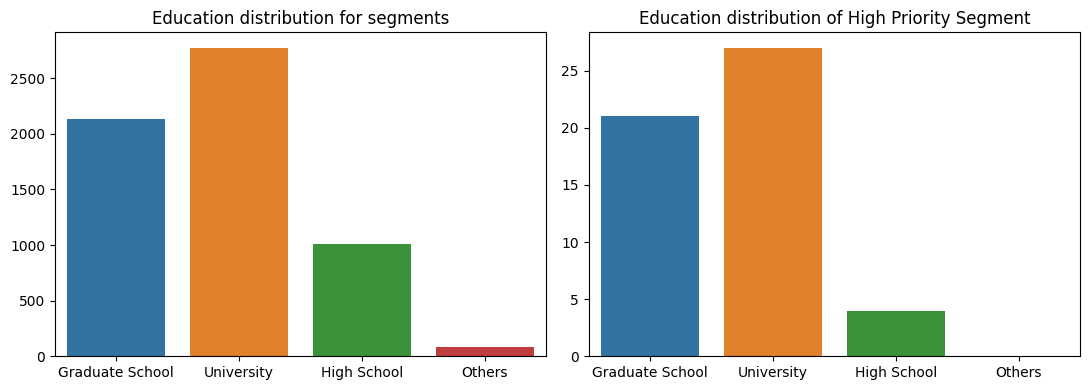

In [74]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
education_columns = ['EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4']
education_labels = ['Graduate School', 'University', 'High School', 'Others']
education_counts = default_df[education_columns].sum()
sns.barplot(x=education_labels, y=education_counts)
plt.title('Education distribution for segments')

plt.subplot(1, 2, 2)
highest_segment_df = default_df[default_df['SEGMENT'] == highest_segment]
highest_segment_education_counts = highest_segment_df[education_columns].sum()
sns.barplot(x=education_labels, y=highest_segment_education_counts)
plt.title(f'Education distribution of High Priority Segment')

plt.grid(False)
plt.tight_layout()
plt.show()

# (1 = graduate school; 2 = university; 3 = high school; 4 = others)

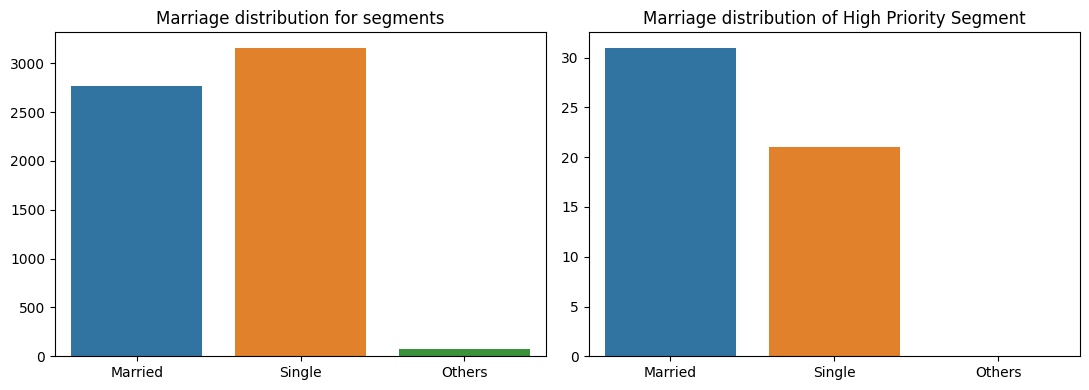

In [67]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
marriage_columns = ['MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3']
marriage_labels = ['Married', 'Single', 'Others']
marriage_counts = default_df[marriage_columns].sum()
sns.barplot(x=marriage_labels, y=marriage_counts)
plt.title('Marriage distribution for segments')

plt.subplot(1, 2, 2)
highest_segment_df = default_df[default_df['SEGMENT'] == highest_segment]
highest_segment_marriage_counts = highest_segment_df[marriage_columns].sum()
sns.barplot(x=marriage_labels, y=highest_segment_marriage_counts)
plt.title(f'Marriage distribution of High Priority Segment')

plt.grid(False)
plt.tight_layout()
plt.show()


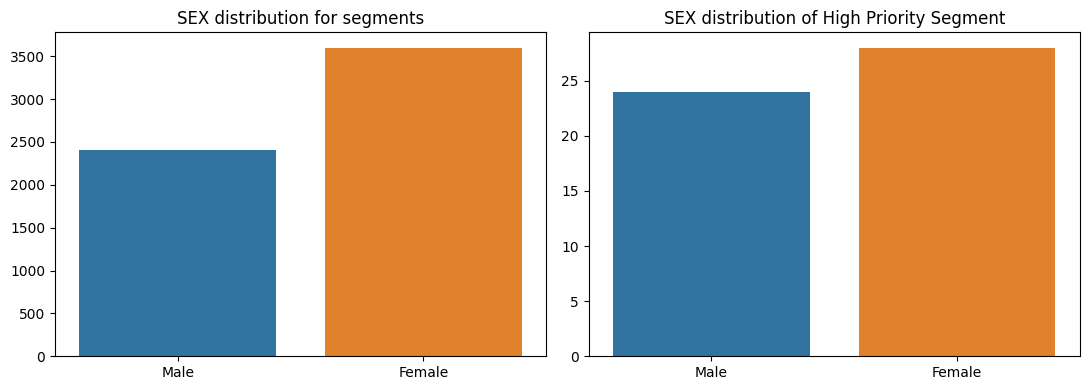

In [68]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
sex_columns = ['SEX_1', 'SEX_2']
sex_labels = ['Male', 'Female']
sex_counts = default_df[sex_columns].sum()
sns.barplot(x=sex_labels, y=sex_counts)
plt.title('SEX distribution for segments')

plt.subplot(1, 2, 2)
highest_segment_df = default_df[default_df['SEGMENT'] == highest_segment]
highest_segment_sex_counts = highest_segment_df[sex_columns].sum()
sns.barplot(x=sex_labels, y=highest_segment_sex_counts)
plt.title(f'SEX distribution of High Priority Segment')

plt.grid(False)
plt.tight_layout()
plt.show()


In [76]:
highest_seg_df = default_df.query(f'SEGMENT == {highest_segment}')
seg_debt = highest_seg_df['OUTSTANDING'].sum()
print('Segment outstanding: $', format(seg_debt, ','))

all_debt = default_df[default_df['OUTSTANDING'] > 0]['OUTSTANDING'].sum()
print('% of all outstanding: ', round(seg_debt / all_debt * 100, 2), '%' )

seg_debt_defaulted = highest_seg_df.query('`default payment next month` == 1')['OUTSTANDING'].sum()
print('Segment outstanding that default: $', format(seg_debt_defaulted, ','))

all_default = default_df.query('`default payment next month` == 1')['OUTSTANDING'].sum()
print('Total default: $', format(all_default, ','))

seg_default_percentage = (seg_debt_defaulted / all_default) * 100
print('Segment default as % of total default:', round(seg_default_percentage, 2), '%')

Segment outstanding: $ 79,136,373
% of all outstanding:  5.44 %
Segment outstanding that default: $ 62,793,194
Total default: $ 338,901,128
Segment default as % of total default: 18.53 %


# **Demographics of 4 segments:**

by order of default importance: Segment 2, Segment 0, Segment 1, Segment 3

**Seg 2(highest priority: high outstanding, high prob)**


*   5.44% of all segments
*   high default probability, high outstanding

*   high default importance
*   highest median default probability

*   highest total bill amount (by median and distribution)
*   education distribution: university, graduate school, high school (similar with segment 0 and segment 1)

*   marriage distribution: more married than singles (different from segment 1)
*   sex distribution: more male than female (different from all other segments and the total population sex distribution)

**Seg 0(middle segment: low limit balance, relatively high default prob)**

*   relatively high default probability, the second highest outstanding balance
*   low limit balance but not the lowest, the second highest default importance
*   middle median default probability
*   the second highest total bill amount(by median)

*   the second highest mean bill amount, the second lowest mean payment amount
*   education distribution: university, graduate school, high school (similar with segment 2 and segment 1)

*   marriage distribution: more married than singles
*   sex distribution: more females than males (reflective of total population sex distribution)

**Seg 1(middle segment: low outstanding, relatively low default prob)**

*   relatively low default probability, low outstanding balance
*   the highest percentage of all population

*   lowest limit balance, relatively low default importance
*   the second lowest median default probability

*   the second lowest total bill amount (by median, with some outliers above segment 2)
*   the second lowest mean bill amount, the lowest bill payment amount

*   education distribution: university, graduate school, high school
*   merriage distribution: more singles than married

*   sex distribution: more females than males

**Seg 3 (lowest segment: lowest outstanding, low default prob)**

*   low default probability, lowest outstanding balance
*   highest limit balance, lowest default importance

*   lowest median default probability
*   lowest total bill amount (by median, with some outliers above segment 2)

*   lowest mean bill amount, highest mean payment amount
*   education distribution: graduate school, university, high school (has more higher education)

*   marriage distribution: slightly more singles than married
*   sex distribution: more females than males (reflective of total population sex distribution)








































**--------------------------------------------------**

**Repay Status Clustering and Linear Probability Model**

After some further data exploration, it was found that the grouping results of repayment status have a strong explanatory power for the default rate of customers. Therefore, the K-Mean Clutser method is then used again to group customers according to their repayment status from April to September. After grouping, use the Linear Probability Model to calculate the default rate of each customer group, and check whether the grouping results are significant.


In [77]:
from sklearn.cluster import KMeans

full_data = pd.read_csv("default of credit card clients.csv")
repay_status = full_data[['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_0']]
is_default = full_data['default payment next month']

n_clusters = 10
kmean_model = KMeans(n_clusters=n_clusters, random_state=1).fit(repay_status)
cluster_label = kmean_model.predict(repay_status)

cluster_label = pd.Series(cluster_label)
cluster_label.index = is_default.index

In [78]:
cluster_counts = cluster_label.value_counts().sort_index()
cluster_counts.index = ['cluster_'+str(i) for i in cluster_counts.index]
cluster_counts = pd.DataFrame(cluster_counts)
cluster_counts.columns = ['Number of People']
print('KMean Cluster number of people in groups：')
cluster_counts

KMean Cluster number of people in groups：


Number of People
cluster_0              2706
cluster_1               962
cluster_2             13455
cluster_3              1908
cluster_4              4637
cluster_5               130
cluster_6              1267
cluster_7              1700
cluster_8              1444
cluster_9              1791

In [79]:
cluster_dummy = pd.get_dummies(cluster_label, prefix='cluster')
cluster_dummy = cluster_dummy.join(is_default)

In [80]:
import statsmodels.api as sm

dependent_variable = cluster_dummy['default payment next month']
independent_variables = sm.add_constant(cluster_dummy.iloc[:, :-2])

model = sm.OLS(dependent_variable, independent_variables)
result = model.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
=============================================================================
Model:              OLS                        Adj. R-squared:     0.131     
Dependent Variable: default payment next month AIC:                28164.2911
Date:               2023-08-23 12:57           BIC:                28247.3806
No. Observations:   30000                      Log-Likelihood:     -14072.   
Df Model:           9                          F-statistic:        504.8     
Df Residuals:       29990                      Prob (F-statistic): 0.00      
R-squared:          0.132                      Scale:              0.14966   
---------------------------------------------------------------------------------
               Coef.      Std.Err.        t        P>|t|       [0.025      0.975]
---------------------------------------------------------------------------------
const          0.1960       0.0091     21.4392     0.0000      0.1781      0.2139
cluster_0     -0.0556       0.0118     -4.7140     0.0000     -0.0786     -0.0325
cluster_1      0.3331       0.0155     21.5422     0.0000      0.3028      0.3634
cluster_2     -0.0509       0.0097     -5.2313     0.0000     -0.0700     -0.0318
cluster_3      0.0682       0.0127      5.3560     0.0000      0.0432      0.0931
cluster_4     -0.0623       0.0108     -5.7860     0.0000     -0.0834     -0.0412
cluster_5      0.4886       0.0351     13.9056     0.0000      0.4198      0.5575
cluster_6      0.1545       0.0142     10.8759     0.0000      0.1266      0.1823
cluster_7      0.2905       0.0131     22.1758     0.0000      0.2648      0.3162
cluster_8      0.4688       0.0137     34.2664     0.0000      0.4420      0.4957
-----------------------------------------------------------------------------
Omnibus:                4906.504          Durbin-Watson:             2.002   
Prob(Omnibus):          0.000             Jarque-Bera (JB):          7707.947
Skew:                   1.225             Prob(JB):                  0.000   
Kurtosis:               3.403             Condition No.:             19      
=============================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
"""

It can be seen that the coefficients of cluster_0 to cluster_8 are significantly different from those of const, that is, the default rate of each cluster is different. After adding const to each coefficient, the default rate of each cluster is obtained. E.g., the default rate for cluster_5 is 0.1960+0.4886=68.46%. The adjusted R square in the model is 0.131, as the number of clusters increases, the adjusted R square should increase.

In [81]:
cluster_ols_params = result.params
cluster_default_rate = (cluster_ols_params[1:]+cluster_ols_params[0]).append(
                        pd.Series(cluster_ols_params[0],
                        index=['cluster_'+str(len(cluster_ols_params)-1)]))

cluster_default_rate = pd.DataFrame(cluster_default_rate)
cluster_default_rate.columns = ['default rate']
cluster_default_rate.join(cluster_counts)

default rate  Number of People
cluster_0      0.140429              2706
cluster_1      0.529106               962
cluster_2      0.145076             13455
cluster_3      0.264151              1908
cluster_4      0.133707              4637
cluster_5      0.684615               130
cluster_6      0.350434              1267
cluster_7      0.486471              1700
cluster_8      0.664820              1444
cluster_9      0.195980              1791

Firstly use K-Mean Clustering to group customers, and then use Linear Probability Model to quickly get the default rate of each group, and at the same time test whether each group is significant. Here we can see that Cluster_0 and Cluster_2 have the lowest default rate, only about 14%. And Cluster_5 and Cluster_8 have the highest default rate, with a default rate of nearly 70%.

In the previous grouping, 10 groups were directly selected, and the adjusted R square is 0.131, but the number of groups will increase the adjusted R square of the Linear Probability Model, which means that the explanatory power will be enhanced, but too small a group may also cause the Linear Probability Model to reduce the explanatory power because of too many parameters, so here I will test the results of the number of clusters from 3 to 50, and determine the final number of clusters according to the adjusted R square and the number of non-significant coefficients.

In [82]:
def loop_n_cluster(n_clusters):
    kmean_model = KMeans(n_clusters=n_clusters, random_state=1).fit(repay_status)
    cluster_label = kmean_model.predict(repay_status)

    cluster_label = pd.Series(cluster_label)
    cluster_label.index = is_default.index

    cluster_dummy = pd.get_dummies(cluster_label, prefix='cluster')
    cluster_dummy = cluster_dummy.join(is_default)

    dependent_variable = cluster_dummy['default payment next month']
    independent_variables = sm.add_constant(cluster_dummy.iloc[:, :-2])

    model = sm.OLS(dependent_variable, independent_variables)
    result = model.fit()

    return result.rsquared_adj, (result.pvalues>0.05).value_counts()[False]

In [83]:
cluster_n_choose = pd.DataFrame(columns=['Number of Clusters', 'Adjusted R^2',
                                         'Number of Insignificant Coefficients'])

for n in range(2,51):
    rsq, significant = loop_n_cluster(n)
    cluster_n_choose = cluster_n_choose.append(
                            pd.DataFrame({'Number of Clusters':[n],
                                          'Adjusted R^2':[rsq],
                                          'Number of Insignificant Coefficients':[n-significant]}))

cluster_n_choose.set_index('Number of Clusters', inplace=True)

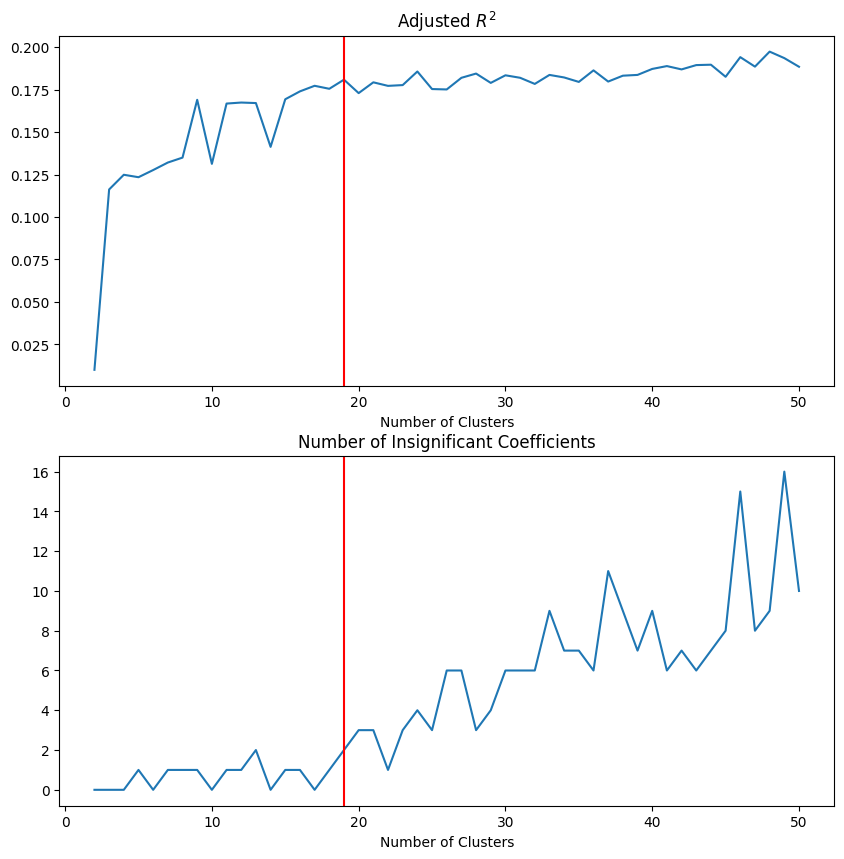

In [84]:
fig, ax = plt.subplots(figsize=(10,10))

plt.subplot(211)
plt.plot(cluster_n_choose['Adjusted R^2'])
ax.text(19,0.1,'Number of Cluster = 19')
plt.title('Adjusted $R^2$')
plt.axvline(x=19, color='red')
plt.xlabel('Number of Clusters')


plt.subplot(212)
plt.plot(cluster_n_choose['Number of Insignificant Coefficients'])
plt.axvline(x=19, color='red')
plt.title('Number of Insignificant Coefficients')
plt.xlabel('Number of Clusters')
plt.show()

It can be seen that after the number of clusters is 19, the Adjusted R-squared increase rate slows down, and the number of insignificant coefficients begin to rise rapidly. So 19 clusters are selected here as the hyperparameter of K-Mean Cluster.

In [85]:
n_clusters = 19
kmean_model = KMeans(n_clusters=n_clusters, random_state=1).fit(repay_status)
cluster_label = kmean_model.predict(repay_status)

cluster_label = pd.Series(cluster_label)
cluster_label.index = is_default.index

In [86]:
cluster_counts = cluster_label.value_counts().sort_index()
cluster_counts.index = ['cluster_'+str(i) for i in cluster_counts.index]
cluster_counts = pd.DataFrame(cluster_counts)
cluster_counts.columns = ['Number of People']

In [87]:
cluster_dummy = pd.get_dummies(cluster_label, prefix='cluster')
cluster_dummy = cluster_dummy.join(is_default)

In [88]:
dependent_variable = cluster_dummy['default payment next month']
independent_variables = sm.add_constant(cluster_dummy.iloc[:, :-2])

model = sm.OLS(dependent_variable, independent_variables)
result = model.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
=============================================================================
Model:              OLS                        Adj. R-squared:     0.181     
Dependent Variable: default payment next month AIC:                26410.9153
Date:               2023-08-23 12:58           BIC:                26568.7854
No. Observations:   30000                      Log-Likelihood:     -13186.   
Df Model:           18                         F-statistic:        369.0     
Df Residuals:       29981                      Prob (F-statistic): 0.00      
R-squared:          0.181                      Scale:              0.14112   
--------------------------------------------------------------------------------
                  Coef.     Std.Err.       t        P>|t|      [0.025     0.975]
--------------------------------------------------------------------------------
const             0.2506      0.0130     19.2650    0.0000     0.2251     0.2761
cluster_0         0.3653      0.0185     19.7708    0.0000     0.3290     0.4015
cluster_1        -0.1185      0.0142     -8.3461    0.0000    -0.1464    -0.0907
cluster_2         0.3464      0.0477      7.2621    0.0000     0.2529     0.4399
cluster_3        -0.1445      0.0135    -10.7129    0.0000    -0.1709    -0.1181
cluster_4        -0.1102      0.0149     -7.4049    0.0000    -0.1393    -0.0810
cluster_5         0.4503      0.0168     26.7532    0.0000     0.4173     0.4833
cluster_6         0.1910      0.0173     11.0653    0.0000     0.1572     0.2248
cluster_7         0.3116      0.0190     16.4228    0.0000     0.2744     0.3487
cluster_8        -0.0164      0.0193     -0.8506    0.3950    -0.0542     0.0214
cluster_9         0.1728      0.0189      9.1459    0.0000     0.1358     0.2099
cluster_10        0.0382      0.0171      2.2395    0.0251     0.0048     0.0716
cluster_11       -0.0022      0.0198     -0.1104    0.9121    -0.0411     0.0367
cluster_12        0.5332      0.0456     11.7014    0.0000     0.4439     0.6225
cluster_13        0.3358      0.0197     17.0710    0.0000     0.2973     0.3744
cluster_14       -0.0603      0.0191     -3.1588    0.0016    -0.0976    -0.0229
cluster_15       -0.1259      0.0187     -6.7250    0.0000    -0.1626    -0.0892
cluster_16       -0.1142      0.0171     -6.6641    0.0000    -0.1477    -0.0806
cluster_17        0.1413      0.0216      6.5326    0.0000     0.0989     0.1838
-----------------------------------------------------------------------------
Omnibus:                4689.873          Durbin-Watson:             2.006   
Prob(Omnibus):          0.000             Jarque-Bera (JB):          7191.489
Skew:                   1.157             Prob(JB):                  0.000   
Kurtosis:               3.629             Condition No.:             31      
=============================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
"""

In [89]:
cluster_ols_params = result.params
cluster_default_rate = (cluster_ols_params[1:]+cluster_ols_params[0]).append(
                        pd.Series(cluster_ols_params[0],
                        index=['cluster_'+str(len(cluster_ols_params)-1)]))

cluster_default_rate = pd.DataFrame(cluster_default_rate)
cluster_default_rate.columns = ['Default Rate']
print('n_cluster=19 default rate and the number of people in the group：')
cluster_default_rate.join(cluster_counts)

n_cluster=19 default rate and the number of people in the group：


Default Rate  Number of People
cluster_0       0.615854               820
cluster_1       0.132058              4339
cluster_2       0.597015                67
cluster_3       0.106103             11093
cluster_4       0.140429              2706
cluster_5       0.700889              1237
cluster_6       0.441606              1096
cluster_7       0.562162               740
cluster_8       0.234195               696
cluster_9       0.423435               751
cluster_10      0.288793              1160
cluster_11      0.248408               628
cluster_12      0.783784                74
cluster_13      0.586420               648
cluster_14      0.190345               725
cluster_15      0.124679               778
cluster_16      0.136444              1136
cluster_17      0.391949               472
cluster_18      0.250600               834

Assuming a gavin default probability threshold, if the default probability of the user after grouping exceeds the threshold, the user is set to default, and the overall accuracy rate is calculated according to this rule.

In [90]:
from sklearn.metrics import accuracy_score

default_rate_map = cluster_default_rate
default_rate_map.index = list(range(n_clusters))

cluster_simul = cluster_label.map(default_rate_map.iloc[:,0])
cluster_simul = pd.DataFrame(cluster_simul).join(is_default)
cluster_simul.rename(columns={0:'model_prob'}, inplace=True)

crit_prob = np.arange(0.1,1.0,0.01)

for crit in crit_prob:
    cluster_simul[str(round(crit,2))] = \
            cluster_simul['model_prob'].apply(lambda default_prob:
                                              1 if default_prob>crit else 0)

target_variable = cluster_simul['default payment next month']

model_accuracy = [accuracy_score(target_variable, cluster_simul[c])
                  for c in cluster_simul.columns[2:]]
model_accuracy = pd.Series(model_accuracy)
model_accuracy.index = crit_prob

In [91]:
model_accuracy

0.10    0.221200
0.11    0.512500
0.12    0.512500
0.13    0.531967
0.14    0.665933
0.15    0.730800
0.16    0.730800
0.17    0.730800
0.18    0.730800
0.19    0.730800
0.20    0.745767
0.21    0.745767
0.22    0.745767
0.23    0.745767
0.24    0.758100
0.25    0.768633
0.26    0.782500
0.27    0.782500
0.28    0.782500
0.29    0.798833
0.30    0.798833
0.31    0.798833
0.32    0.798833
0.33    0.798833
0.34    0.798833
0.35    0.798833
0.36    0.798833
0.37    0.798833
0.38    0.798833
0.39    0.798833
0.40    0.802233
0.41    0.802233
0.42    0.802233
0.43    0.806067
0.44    0.806067
0.45    0.810333
0.46    0.810333
0.47    0.810333
0.48    0.810333
0.49    0.810333
0.50    0.810333
0.51    0.810333
0.52    0.810333
0.53    0.810333
0.54    0.810333
0.55    0.810333
0.56    0.810333
0.57    0.807267
0.58    0.807267
0.59    0.803533
0.60    0.803100
0.61    0.803100
0.62    0.796767
0.63    0.796767
0.64    0.796767
0.65    0.796767
0.66    0.796767
0.67    0.796767
0.68    0.7967

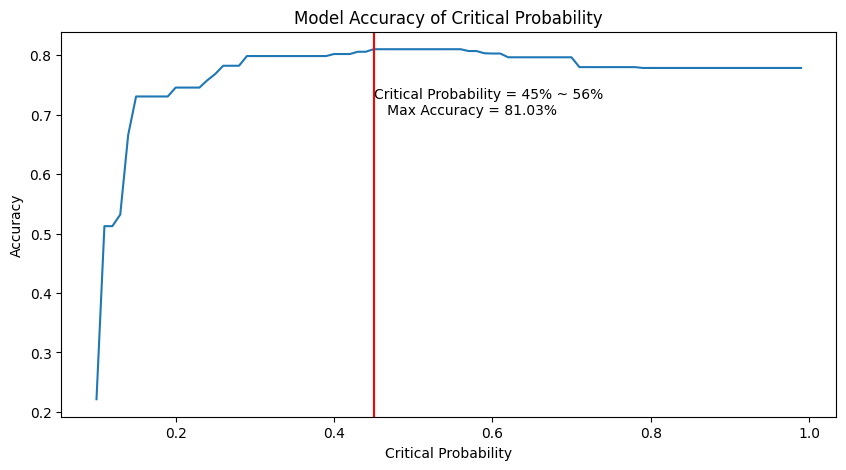

In [92]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(model_accuracy)
ax.text(0.45, 0.7, 'Critical Probability = 45% ~ 56% \n   Max Accuracy = 81.03%')
plt.axvline(x=0.45, color='red')
plt.title('Model Accuracy of Critical Probability')
plt.xlabel('Critical Probability')
plt.ylabel('Accuracy')
plt.show()

In the case of 19 groups, when the default probability threshold is set at 45% to 56%, the accuracy of this model is the highest, reaching 81.15%.